In [1]:
import time
# !pip install ipympl # Run to install the required library in google colab
%matplotlib widget
# from google.colab import output # Uncomment to enable matplotlib widget
# output.enable_custom_widget_manager() # Uncomment to enable matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import datetime
import matplotlib.dates as mdates
from collections import deque
import numpy as np
from numpy import linalg as LA
from scipy.signal import savgol_filter
from scipy.spatial.transform import Rotation
import ipympl
import serial
import serial.tools.list_ports
import re
import os
import sys
import copy
import timeit
import wmm2020
from datetime import datetime as dt
import websocket
import json

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def uniquify(path):
    filename, extension = os.path.splitext(path);
    counter = 1;
    while os.path.exists(path):
        path = filename+'('+str(counter)+')'+extension;
        counter += 1;
    return path;

def matrix_cofactor(matrix):
    return np.linalg.inv(matrix).T * np.linalg.det(matrix)

def matrix_adj(matrix):
    return matrix_cofactor(matrix).T

def parse_message(ws):
    values = json.loads(ws.recv())['values']
    x = values[0]
    y = values[1]
    z = values[2]
    return x, y, z

# How many sensor samples we want to store
HISTORY_SIZE_MAG_ACCEL = 12
HISTORY_SIZE_GYRO = int(2500/3)
SAMPLE_SIZE_MAG_ACCEL = 30
SAMPLE_SIZE_GYRO = 200

# Rotation matrix to align magnetometer axes to accelerometer and gyroscope axes
mag_align = Rotation.from_euler('ZX', [90, 180], degrees=True) # Upper case for intrinsic rotation, lower for extrinsic rotation
mag_align = mag_align.as_matrix()

# Pause re-sampling the sensor and drawing for INTERVAL seconds
INTERVAL = 0.01

# Current location latitude, longitude, altitude and date in decimal year
LAT = -27.5937984
LON = -48.5424890
ALT = 0.0
DAT = toYearFraction(dt.today())

ADDR = "192.168.15.207"

Put down the board and do not touch or move it!
3...2...1...COLLECTING GYRO DATA
Gyroscope bias:  [-8.35863171e-05  5.43224954e-05  3.64641585e-04]


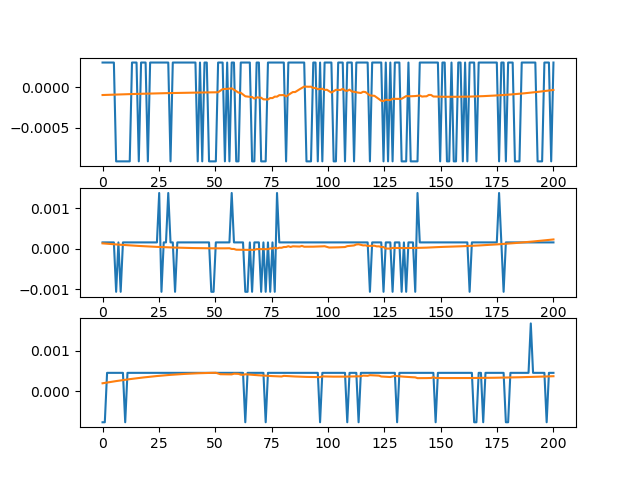

In [2]:
ws_gyro = websocket.WebSocket()
ws_gyro.connect("ws://" + ADDR + ":8080/sensor/connect?type=android.sensor.gyroscope")
samples = np.linspace(0, SAMPLE_SIZE_GYRO, SAMPLE_SIZE_GYRO)
print("Put down the board and do not touch or move it!")
for s in range(3, 0, -1):
    print(s, end='...')
    time.sleep(1)
print("COLLECTING GYRO DATA")

# Deque for axes
gyro_x = deque(maxlen=SAMPLE_SIZE_GYRO)
gyro_y = deque(maxlen=SAMPLE_SIZE_GYRO)
gyro_z = deque(maxlen=SAMPLE_SIZE_GYRO)
while len(gyro_x) < (SAMPLE_SIZE_GYRO):
    ret = parse_message(ws_gyro)
    #print(ret)
    if not ret:
        continue
    x, y, z = ret[0:3]
    gyro_x.append(x)
    gyro_y.append(y)
    gyro_z.append(z)

gyro_bias = np.array([savgol_filter(gyro_x, int(SAMPLE_SIZE_GYRO/2) + 1, 2),\
                    savgol_filter(gyro_y, int(SAMPLE_SIZE_GYRO/2) + 1, 2),\
                    savgol_filter(gyro_z, int(SAMPLE_SIZE_GYRO/2) + 1, 2)])
wstill = np.array([np.mean(gyro_bias[0]), np.mean(gyro_bias[1]), np.mean(gyro_bias[2])])
print('Gyroscope bias: ', wstill)
plt.close(1)
plt.figure(1)
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(samples, gyro_x, samples, gyro_bias[0])
plt.subplot(3, 1, 2)
plt.plot(samples, gyro_y, samples, gyro_bias[1])
plt.subplot(3, 1, 3)
plt.plot(samples, gyro_z, samples, gyro_bias[2]);
ws_gyro.close()

# IMU and Magnetometer Alignment

In [ ]:
# Deque for axes
ws_mag = websocket.WebSocket()
ws_accel = websocket.WebSocket()
ws_gyro = websocket.WebSocket()
accel_x = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
accel_y = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
accel_z = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
gyro_x = deque(maxlen=3)
gyro_y = deque(maxlen=3)
gyro_z = deque(maxlen=3)
gyro_aux_x = deque(maxlen=HISTORY_SIZE_GYRO*3)
gyro_aux_y = deque(maxlen=HISTORY_SIZE_GYRO*3)
gyro_aux_z = deque(maxlen=HISTORY_SIZE_GYRO*3)
mag_x = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
mag_y = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
mag_z = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
mx = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
my = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
mz = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
acx = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
acy = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
acz = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)

ret = [None]*9
mag_size = 0
rate = deque(maxlen=3)
turn = deque(maxlen=3)
clicks = deque(maxlen=15)
ax = []
plt.close(0)
fig = plt.figure(0)
plt.clf()
ax.append(fig.add_subplot(2, 2, 1, projection='3d'))
ax.append(fig.add_subplot(2, 2, 2, projection='3d'))
ax.append(fig.add_subplot(3, 1, 3))
ax[2].set_aspect(1)

def onClick(event):
    ws_mag.connect("ws://" + ADDR + ":8080/sensor/connect?type=android.sensor.magnetic_field", max_queue=1)
    ws_accel.connect("ws://" + ADDR + ":8080/sensor/connect?type=android.sensor.accelerometer", max_queue=1)
    ws_gyro.connect("ws://" + ADDR + ":8080/sensor/connect?type=android.sensor.gyroscope", max_queue=1)
    if event.button == 1:
        clicks.append(1)
        
    if event.button == 1 and (len(clicks)) in [2, 7, 12]:
        skip = True # Skip first sample after flushing input buffer, 
                # since the last sample remains in buffer 
                # (possibly due to the serial/USB converter)
        gyro_x.append(deque(maxlen=HISTORY_SIZE_GYRO))
        gyro_y.append(deque(maxlen=HISTORY_SIZE_GYRO))
        gyro_z.append(deque(maxlen=HISTORY_SIZE_GYRO))

        start = timeit.default_timer()
        for _ in range(SAMPLE_SIZE_GYRO):
            ret[3:6] = parse_message(ws_gyro)
            ret[6:9] = parse_message(ws_mag)
            if not ret:
                continue
            else:
                if skip:
                    skip = False
                    continue
                x, y, z = ret[6:9]
                if max(abs(x), abs(y), abs(z)) < 100:
                    gyro_aux_x.append(x)
                    gyro_aux_y.append(y)
                    gyro_aux_z.append(z)
                    gyro_x[len(turn)].append(ret[3])
                    gyro_y[len(turn)].append(ret[4])
                    gyro_z[len(turn)].append(ret[5])
        rate.append((timeit.default_timer() - start)/SAMPLE_SIZE_GYRO)
    
        turn.append(1)
    elif event.button == 1 and len(mag_x) < 12:
        skip = True # Skip first sample after flushing input buffer, 
                # since the last sample remains in buffer 
                # (possibly due to the serial/USB converter)
        mx.clear()
        my.clear()
        mz.clear()
        acx.clear()
        acy.clear()
        acz.clear()
        for _ in range(SAMPLE_SIZE_MAG_ACCEL):
            ret[0:3] = parse_message(ws_accel)
            ret[6:9] = parse_message(ws_mag)
            if not ret:
                continue
            else:
                if skip:
                    skip = False
                    continue
                acx.append(ret[0])
                acy.append(ret[1])
                acz.append(ret[2])
                mx.append(ret[6])
                my.append(ret[7])
                mz.append(ret[8])

        accel_x.append(np.median(acx))
        accel_y.append(np.median(acy))
        accel_z.append(np.median(acz))
        mag_x.append(np.median(mx))
        mag_y.append(np.median(my))
        mag_z.append(np.median(mz))
    elif event.button == 3:
        if (len(clicks)) in [2, 7, 12]:
            gyro_x.pop()
            gyro_y.pop()
            gyro_z.pop()
            turn.pop()
        else:
            mag_x.pop()
            mag_y.pop()
            mag_z.pop()
            accel_x.pop()
            accel_y.pop()
            accel_z.pop()
        clicks.pop()
    elif event.button == 1:
        fig.canvas.mpl_disconnect(onClickId)

    msg = 'button='+str(event.button)+'\nrate='+','.join(map(str, rate))+'\nclicks='+str(len(clicks))+\
    '\ndeque_size='+str(len(mag_x))+'\nmag_data='+','.join(map(str, mag_x))+'/'+','.join(map(str, mag_y))+'/'+\
    ','.join(map(str, mag_z))+', accel_data='+','.join(map(str, accel_x))+'/'+','.join(map(str, accel_y))+'/'+\
    ','.join(map(str, accel_z))+'\n'
    os.write(1, msg.encode())
    ws_mag.close()    
    ws_accel.close()
    ws_gyro.close()

def animate(i):
    # Clear all axis
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()

    fig.suptitle("Step "+str(len(mag_x) + len(gyro_x)))
    ax[0].set_title("Mag sample(s) "+str(len(mag_x)))
    ax[1].set_title("Accel sample(s) "+str(len(accel_x)))
    ax[2].set_title("Mag vector planes sample(s) "+str(len(gyro_x)))
    
    # # Display the sub-plots
    ax[0].scatter(mag_x, mag_y, mag_z)
    ax[1].scatter(accel_x, accel_y, accel_z)
    ax[2].scatter(gyro_aux_x, gyro_aux_y, color='r')
    ax[2].scatter(gyro_aux_y, gyro_aux_z, color='g')
    ax[2].scatter(gyro_aux_z, gyro_aux_x, color='b')
                    
    ax[0].set_aspect("equal")
    ax[1].set_aspect("equal")
    ax[2].grid()
    
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].set_zlabel('Z')
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y')
    ax[1].set_zlabel('Z')
        
    plt.pause(INTERVAL)

onClickId = fig.canvas.mpl_connect('button_press_event', onClick)
anim = FuncAnimation(fig, animate, frames=19)

In [ ]:
accel_xyz = []
gyro_xyz = [[], [], []]
mag_xyz = []

for i in range(3):
    odd = int(len(gyro_x[i])/2) % 2
    gyro_filt = [savgol_filter(gyro_x[i], int(len(gyro_x[i])/2) + odd, 2),\
     savgol_filter(gyro_y[i], int(len(gyro_y[i])/2) + odd, 2),\
     savgol_filter(gyro_z[i], int(len(gyro_z[i])/2) + odd, 2)]
    for j in range(len(gyro_x[i])):
        gyro_xyz[i].append([gyro_filt[0][j], gyro_filt[1][j], gyro_filt[2][j]])

for i in range(len(accel_x)):
    accel_xyz.append([accel_x[i], accel_y[i], accel_z[i]])
    mag_xyz.append([mag_x[i], mag_y[i], mag_z[i]])

accel_xyz = np.array(accel_xyz)
gyro_xyz = np.array(gyro_xyz, dtype=object)
mag_xyz = np.array(mag_xyz)

print(accel_xyz, '\n', gyro_xyz, '\n', mag_xyz)
np.savetxt(uniquify('accel_dataset.csv'), accel_xyz, delimiter=',')
np.savetxt(uniquify('gyro_1_dataset.csv'), gyro_xyz[0], delimiter=',')
np.savetxt(uniquify('gyro_2_dataset.csv'), gyro_xyz[1], delimiter=',')
np.savetxt(uniquify('gyro_3_dataset.csv'), gyro_xyz[2], delimiter=',')
np.savetxt(uniquify('mag_dataset.csv'), mag_xyz, delimiter=',')

In [ ]:
serialport = None

def get_imu_data(rst=False):
    global serialport
    
    if not serialport:
        ports = list(serial.tools.list_ports.comports())
        for p in ports:
            if "ACM" in p.device:
                PORT = p.device
        # open serial port
        serialport = serial.Serial(PORT, 57600, timeout=3)
        # check which port was really used
        print("Opened", serialport.name)
        # Flush input
        time.sleep(3)
        serialport.readline()
    
    # Poll the serial port
    line = str(serialport.readline(), 'utf-8', errors = 'ignore')
    if not line:
        return None
    #print(line)
    if not "Uni:" in line:
        return None
    vals = line.replace("Uni:", "").strip().split(',')
    #print(vals)
    if len(vals) != 9:
        return None
    try:
        vals = [float(i) for i in vals]
    except ValueError:
        return None
    #print(vals)

    if rst:
        serialport.reset_input_buffer()
    
    return vals

for _ in range(30):
    print(get_imu_data())

# Gyroscope offset calibration

In [ ]:
samples = np.linspace(0, SAMPLE_SIZE_GYRO, SAMPLE_SIZE_GYRO)
print("Put down the board and do not touch or move it!")
for s in range(3, 0, -1):
    print(s, end='...')
    time.sleep(1)
print("COLLECTING GYRO DATA")

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None

# Deque for axes
gyro_x = deque(maxlen=SAMPLE_SIZE_GYRO)
gyro_y = deque(maxlen=SAMPLE_SIZE_GYRO)
gyro_z = deque(maxlen=SAMPLE_SIZE_GYRO)
while len(gyro_x) < (SAMPLE_SIZE_GYRO):
    ret = get_imu_data()
    #print(ret)
    if not ret:
        continue
    x, y, z = ret[3:6]
    gyro_x.append(x)
    gyro_y.append(y)
    gyro_z.append(z)

gyro_bias = np.array([savgol_filter(gyro_x, int(SAMPLE_SIZE_GYRO/2) + 1, 2),\
                    savgol_filter(gyro_y, int(SAMPLE_SIZE_GYRO/2) + 1, 2),\
                    savgol_filter(gyro_z, int(SAMPLE_SIZE_GYRO/2) + 1, 2)])
wstill = np.array([np.mean(gyro_bias[0]), np.mean(gyro_bias[1]), np.mean(gyro_bias[2])])
print('Gyroscope bias: ', wstill)
plt.close(1)
plt.figure(1)
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(samples, gyro_x, samples, gyro_bias[0])
plt.subplot(3, 1, 2)
plt.plot(samples, gyro_y, samples, gyro_bias[1])
plt.subplot(3, 1, 3)
plt.plot(samples, gyro_z, samples, gyro_bias[2]);

# Magnetometer/Accelerometer data capture

In [ ]:
# Deque for axes
accel_x = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
accel_y = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
accel_z = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
gyro_x = deque(maxlen=3)
gyro_y = deque(maxlen=3)
gyro_z = deque(maxlen=3)
gyro_aux_x = deque(maxlen=HISTORY_SIZE_GYRO*3)
gyro_aux_y = deque(maxlen=HISTORY_SIZE_GYRO*3)
gyro_aux_z = deque(maxlen=HISTORY_SIZE_GYRO*3)
mag_x = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
mag_y = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
mag_z = deque(maxlen=HISTORY_SIZE_MAG_ACCEL)
mx = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
my = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
mz = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
acx = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
acy = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)
acz = deque(maxlen=SAMPLE_SIZE_MAG_ACCEL)

mag_size = 0
rate = deque(maxlen=3)
turn = deque(maxlen=3)
clicks = deque(maxlen=15)
ax = []
plt.close(0)
fig = plt.figure(0)
plt.clf()
ax.append(fig.add_subplot(2, 2, 1, projection='3d'))
ax.append(fig.add_subplot(2, 2, 2, projection='3d'))
ax.append(fig.add_subplot(3, 1, 3))
ax[2].set_aspect(1)

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass
serialport = None
anim = None

def onClick(event):
    if event.button == 1:
        clicks.append(1)
        
    if event.button == 1 and (len(clicks)) in [2, 7, 12]:
        skip = True # Skip first sample after flushing input buffer, 
                # since the last sample remains in buffer 
                # (possibly due to the serial/USB converter)

        gyro_x.append(deque(maxlen=HISTORY_SIZE_GYRO))
        gyro_y.append(deque(maxlen=HISTORY_SIZE_GYRO))
        gyro_z.append(deque(maxlen=HISTORY_SIZE_GYRO))

        start = timeit.default_timer()
        for _ in range(SAMPLE_SIZE_GYRO):
            ret = get_imu_data(True)
            if not ret:
                continue
            else:
                if skip:
                    skip = False
                    continue
                x, y, z = mag_align @ ret[6:9]
                if max(abs(x), abs(y), abs(z)) < 100:
                    gyro_aux_x.append(x)
                    gyro_aux_y.append(y)
                    gyro_aux_z.append(z)
                    gyro_x[len(turn)].append(ret[3])
                    gyro_y[len(turn)].append(ret[4])
                    gyro_z[len(turn)].append(ret[5])
        rate.append((timeit.default_timer() - start)/SAMPLE_SIZE_GYRO)
    
        turn.append(1)
    elif event.button == 1 and len(mag_x) < 12:
        skip = True # Skip first sample after flushing input buffer, 
                # since the last sample remains in buffer 
                # (possibly due to the serial/USB converter)

        mx.clear()
        my.clear()
        mz.clear()
        acx.clear()
        acy.clear()
        acz.clear()
        for _ in range(SAMPLE_SIZE_MAG_ACCEL):
            ret = get_imu_data(True)
            if not ret:
                continue
            else:
                if skip:
                    skip = False
                    continue
                acx.append(ret[0])
                acy.append(ret[1])
                acz.append(ret[2])
                mx.append(ret[6])
                my.append(ret[7])
                mz.append(ret[8])

        accel_x.append(np.median(acx))
        accel_y.append(np.median(acy))
        accel_z.append(np.median(acz))
        x, y, z = mag_align @ [mx, my, mz]
        mag_x.append(np.median(x))
        mag_y.append(np.median(y))
        mag_z.append(np.median(z))
    elif event.button == 3:
        if (len(clicks)) in [2, 7, 12]:
            gyro_x.pop()
            gyro_y.pop()
            gyro_z.pop()
            turn.pop()
        else:
            mag_x.pop()
            mag_y.pop()
            mag_z.pop()
            accel_x.pop()
            accel_y.pop()
            accel_z.pop()
        clicks.pop()
    elif event.button == 1:
        fig.canvas.mpl_disconnect(onClickId)

    msg = 'button='+str(event.button)+'\nrate='+','.join(map(str, rate))+'\nclicks='+str(len(clicks))+\
    '\ndeque_size='+str(len(mag_x))+'\nmag_data='+','.join(map(str, mag_x))+'/'+','.join(map(str, mag_y))+'/'+\
    ','.join(map(str, mag_z))+', accel_data='+','.join(map(str, accel_x))+'/'+','.join(map(str, accel_y))+'/'+\
    ','.join(map(str, accel_z))+'\n'
    os.write(1, msg.encode())

def animate(i):
    # Clear all axis
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()

    fig.suptitle("Step "+str(len(mag_x) + len(gyro_x)))
    ax[0].set_title("Mag sample(s) "+str(len(mag_x)))
    ax[1].set_title("Accel sample(s) "+str(len(accel_x)))
    ax[2].set_title("Mag vector planes sample(s) "+str(len(gyro_x)))
    
    # # Display the sub-plots
    ax[0].scatter(mag_x, mag_y, mag_z)
    ax[1].scatter(accel_x, accel_y, accel_z)
    ax[2].scatter(gyro_aux_x, gyro_aux_y, color='r')
    ax[2].scatter(gyro_aux_y, gyro_aux_z, color='g')
    ax[2].scatter(gyro_aux_z, gyro_aux_x, color='b')
                    
    ax[0].set_aspect("equal")
    ax[1].set_aspect("equal")
    ax[2].grid()
    
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].set_zlabel('Z')
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y')
    ax[1].set_zlabel('Z')
        
    plt.pause(INTERVAL)

onClickId = fig.canvas.mpl_connect('button_press_event', onClick)
anim = FuncAnimation(fig, animate, frames=19)

In [ ]:
accel_xyz = []
gyro_xyz = [[], [], []]
mag_xyz = []

for i in range(3):
    odd = int(len(gyro_x[i])/2) % 2
    gyro_filt = [savgol_filter(gyro_x[i], int(len(gyro_x[i])/2) + odd, 2),\
     savgol_filter(gyro_y[i], int(len(gyro_y[i])/2) + odd, 2),\
     savgol_filter(gyro_z[i], int(len(gyro_z[i])/2) + odd, 2)]
    for j in range(len(gyro_x[i])):
        gyro_xyz[i].append([gyro_filt[0][j], gyro_filt[1][j], gyro_filt[2][j]])

for i in range(len(accel_x)):
    accel_xyz.append([accel_x[i], accel_y[i], accel_z[i]])
    mag_xyz.append([mag_x[i], mag_y[i], mag_z[i]])

accel_xyz = np.array(accel_xyz)
gyro_xyz = np.array(gyro_xyz, dtype=object)
mag_xyz = np.array(mag_xyz)

print(accel_xyz, '\n', gyro_xyz, '\n', mag_xyz)
np.savetxt(uniquify('accel_dataset.csv'), accel_xyz, delimiter=',')
np.savetxt(uniquify('gyro_1_dataset.csv'), gyro_xyz[0], delimiter=',')
np.savetxt(uniquify('gyro_2_dataset.csv'), gyro_xyz[1], delimiter=',')
np.savetxt(uniquify('gyro_3_dataset.csv'), gyro_xyz[2], delimiter=',')
np.savetxt(uniquify('mag_dataset.csv'), mag_xyz, delimiter=',')

Tm:  37.94622451525252
Convergence value:  1.1525056630835524


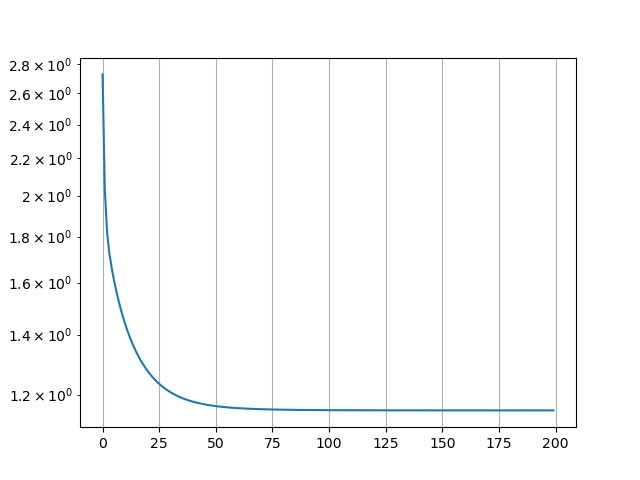

In [3]:
gyro_xyz = [[], [], []]

# Least Squares to solve penalty function with regularization (Convex Optimization, p. 306)
accel_xyz = np.loadtxt('accel_dataset(1).csv', delimiter=',')
gyro_xyz[0] = np.loadtxt('gyro_1_dataset(1).csv', delimiter=',')
gyro_xyz[1] = np.loadtxt('gyro_2_dataset(1).csv', delimiter=',')
gyro_xyz[2] = np.loadtxt('gyro_3_dataset(1).csv', delimiter=',')            
mag_xyz = np.loadtxt('mag_dataset(1).csv', delimiter=',')


J = []
iters = 200
lmbd = 30

mag_xyz = np.array(mag_xyz)
# mag_xyz = mag_xyz/(abs(mag_xyz).max())
# mag_xyz = mag_xyz/LA.norm(mag_xyz)

ymk = mag_xyz
mk = np.array([sample/LA.norm(sample) for sample in ymk])
G = np.block([[np.array(mk).T], [np.ones((1,len(mag_xyz)))]])
Y = ymk.T
for _ in range(iters):
    L = Y @ G.T @ LA.inv(G @ G.T) # @ is the matrix dot product operator, A @ B is the same as np.dot(A,B)
    Tm = L[:,0:3]
    hm = L[:,3]
    mktil = np.array([LA.inv(Tm) @ (ym-hm) for ym in ymk])
    mk = np.array([sample/LA.norm(sample) for sample in mktil])
    G = np.block([[np.array(mk).T], [np.ones((1,len(mag_xyz)))]])
    J.append(np.sum([LA.norm(ymk[k] - (Tm @ mk[k]) - hm)**2 + lmbd*(LA.norm(mk[k])**2 - 1)**2 for k in range(len(mag_xyz))]))
    if _ == 0:
        print('Tm: ', LA.norm(Tm))
print('Convergence value: ', J[-1])
mag_J = J
plt.close(30)
plt.figure(30)
plt.subplot(1,1,1)
plt.clf()
plt.yscale("log")
plt.plot(range(iters), mag_J);
plt.grid()

Ta:  16.98868238051457
Convergence value:  0.00029431845883446403


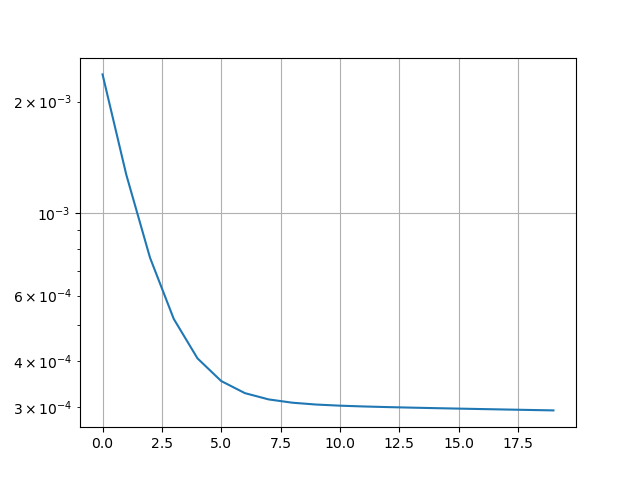

In [4]:
# Least Squares to solve penalty function with regularization (Convex Optimization, p. 306)
J = []
iters = 20
lmbd = 1

accel_xyz = np.array(accel_xyz)
# accel_xyz = accel_xyz/(abs(accel_xyz).max())
# accel_xyz = accel_xyz/LA.norm(accel_xyz)

yak = np.array(accel_xyz).reshape(len(accel_xyz),3) 
fk = np.array([sample/LA.norm(sample) for sample in yak])
G = np.block([[np.array(fk).T], [np.ones((1,len(accel_xyz)))]])
Y = yak.T
for _ in range(iters):
    L = Y @ G.T @ LA.inv(G @ G.T) # @ is the matrix dot product operator, A @ B is the same as np.dot(A,B)
    Ta = L[:,0:3]
    ha = L[:,3]
    fktil = np.array([LA.inv(Ta) @ (ya-ha) for ya in yak])
    fk = np.array([sample/LA.norm(sample) for sample in fktil])
    G = np.block([[np.array(fk).T], [np.ones((1,len(accel_xyz)))]])
    J.append(np.sum([LA.norm(yak[k] - (Ta @ fk[k]) - ha)**2 + lmbd*(LA.norm(fk[k])**2 - 1)**2 for k in range(len(accel_xyz))]))
    if _ == 0:
        print('Ta: ', LA.norm(Ta))
print('Convergence value: ', J[-1])
accel_J = J
plt.close(31)
plt.figure(31)
plt.subplot(1,1,1)
plt.clf()
plt.yscale("log")
plt.plot(range(iters), accel_J);
plt.grid()

Constant:  69.88524310959643
Lambda:  2.3323498684781503e-06
Mu:  7.892391035681185e-08
Lambda + Mu:  2.411273778834962e-06
Convergence value:  5.413138203539234e-07
Rotation matrix: 
 [[ 0.95928965 -0.0407109  -0.0407109 ]
 [-0.0407109   0.95928965 -0.0407109 ]
 [-0.0407109  -0.0407109   0.95928965]] 
delta : 43.265349177551435


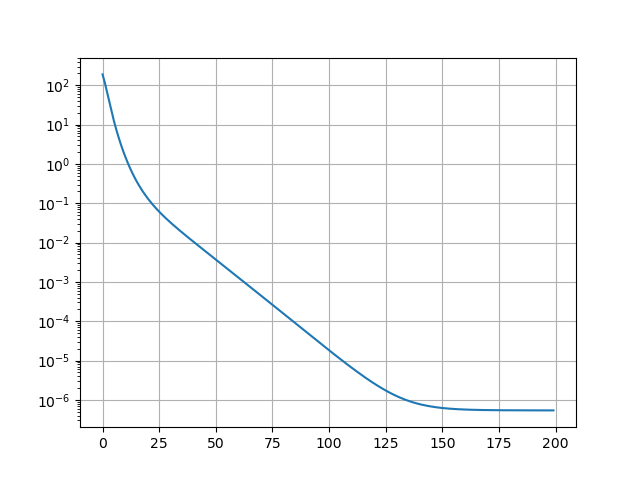

In [223]:
# Angle is reversed?
# Gradient Descent (Convex Optimization, p. 466)
def penalty(x):
    R = x[0:9].reshape(3,3)
    delta = x[-1]
    return np.array([ (np.sin(delta) - (fk[k].T @ R @ mk[k])/(LA.norm(fk[k]) * LA.norm(mk[k]))) \
      for k in range(len(accel_xyz)) ]).sum()**2 +\
    lmbd*(LA.norm(R @ R.T - np.eye(3), ord='fro'))**2 +\
    mu*(LA.det(R) - 1)**2

# Analytical gradient
def gradient(x):
    R = x[0:9].reshape(3,3)
    delta = x[-1]
    grad_x = -2*np.array([ (np.sin(delta) - (fk[k].T @ R @ mk[k])/(LA.norm(fk[k]) * LA.norm(mk[k]))) *\
                      np.kron(mk[k], fk[k])/(LA.norm(fk[k]) * LA.norm(mk[k])) for k in range(len(accel_xyz)) ]).sum() +\
                      4*lmbd*(np.array(R @ R.T @ R - R)).flatten('F') +\
                      2*mu*(LA.det(R) - 1) * ((matrix_adj(R)).T).flatten('F')
    grad_y = 2*np.cos(delta)*np.array([ (np.sin(delta) - (fk[k].T @ R @ mk[k])/(LA.norm(fk[k]) * LA.norm(mk[k]))) \
                           for k in range(len(accel_xyz)) ]).sum()
    return np.block([grad_x.T, grad_y]).T

J = []
iters = 200
lmbd = 1e-5
mu = 1e-6
t = 1
a = 0.15 # Should be in the range between 0 and 0.5 (suggested between 0.01 and 0.3)
b = 0.01 # Should be in the range between 0 and 1 (suggested between 0.1 and 0.8)

R = np.eye(3)
delta = wmm2020.wmm_point(LAT, LON, ALT, DAT)["incl"]*np.pi/180
x = np.block([(R.flatten('F')).T, delta]).T
for _ in range(iters):
    R = x[0:9].reshape(3,3)
    delta = x[-1]
    grad = gradient(x)
    step_x = -grad
    while penalty(x+t*step_x) > penalty(x) + a*t*grad.T @ step_x: # Backtracking line search (Convex Optimization, p.464)
        t = b*t
    x = x+t*step_x
    J.append(penalty(x))
    if _ == 1:
      print('Constant: ', np.array([ ((fk[k].T @ mk[k])/(LA.norm(fk[k]) * LA.norm(mk[k]))) \
      for k in range(len(accel_xyz)) ]).sum()**2)
      print('Lambda: ', lmbd*(LA.norm(R @ R.T - np.eye(3), ord='fro'))**2)
      print('Mu: ', mu*(LA.det(R) - 1)**2)
      print('Lambda + Mu: ', lmbd*(LA.norm(R @ R.T - np.eye(3), ord='fro'))**2 + mu*(LA.det(R) - 1)**2)
print('Convergence value: ', J[-1])
Rm2a = x[0:9].reshape(3,3)
ax_align_J = J
plt.close(32)
plt.figure(32)
plt.subplot(1,1,1)
plt.clf()
plt.yscale("log")
plt.plot(range(iters), ax_align_J);
plt.grid()
print('Rotation matrix: \n', Rm2a, '\ndelta :', x[-1]*180/np.pi)

In [224]:
wmm2020.wmm_point(LAT, LON, ALT, DAT)["incl"]

-42.30412304867306

Convergence value:  13.617510706271643


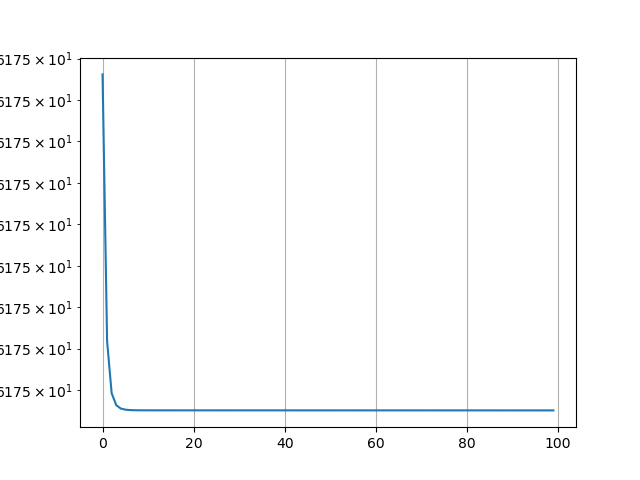

In [189]:
# TODO: check gyro rotation matrix and triad function
def skew_matrix(w):
    wx = w[0]
    wy = w[1]
    wz = w[2]
    return np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])

def triad(fbegin, fend, mbegin, mend):
    a1 = fbegin
    a2 = np.cross(fbegin, mbegin)/LA.norm(np.cross(fbegin, mbegin))
    a3 = np.cross(fbegin, np.cross(fbegin, mbegin))/LA.norm(np.cross(fbegin, mbegin))
    b1 = fend
    b2 = np.cross(fend, mend)/LA.norm(np.cross(fend, mend))
    b3 = np.cross(fend, np.cross(fend, mend))/LA.norm(np.cross(fend, mend))

    return np.array([b1, b2, b3]) @ np.array([a1, a2, a3]).T

# Gradient Descent (Convex Optimization, p. 466)
def penalty(x):
    Hg = x[0:9].reshape(3,3)
    hg = x[9:12].reshape(3,1)
    return np.array([(LA.norm(Ram[n] - Rg[n])**2) for n in range(len(gyro_xyz))]).sum() +\
      (lmbd*LA.norm(Hg @ (wstill - hg))**2)

# Numerical gradient
def gradient(f, x, h=1e-5):
    x_aux = copy.deepcopy(x)
    fx = f(x_aux)
    grad = np.zeros(x.shape)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        old_value = x_aux[ix]
        x_aux[ix] = old_value + h
        fxh = f(x_aux)
        x_aux[ix] = old_value
        grad[ix] = (fxh - fx) / h
        it.iternext()

    return grad

ts = (17e-3)
Rm2a = np.array([[u[0], u[1], u[2]]/LA.norm([u[0], u[1], u[2]]) for u in Rm2a])
Ram = np.array([triad(fk[i], fk[i+1], (Rm2a @ mk[i])/LA.norm(Rm2a @ mk[i]), (Rm2a @ mk[i+1])/LA.norm(Rm2a @ mk[i+1])) for i in [0, 4, 8]])
# Ram = np.array([triad(fk[i], fk[i+1], mk[i], mk[i+1]) for i in [0, 4, 8]])
Rg = [[1], [1], [1]]
J = []
try:
    wstill = np.array(wstill)
except NameError:
    wstill = [0.02041045, 0.00538044, 0.01201833]

iters = 100
lmbd = 1
t = 1
a = 0.15 # Should be in the range between 0 and 0.5 (suggested between 0.01 and 0.3)
b = 0.1 # Should be in the range between 0 and 1 (suggested between 0.1 and 0.8)

for i in range(3):
    gyro_xyz[i] = np.array(gyro_xyz[i])
    # gyro_xyz[i] = gyro_xyz[i]/(abs(gyro_xyz[i]).max())
    # gyro_xyz[i] = gyro_xyz[i]/LA.norm(gyro_xyz[i])
    for j in range(len(gyro_xyz[i])):
        if LA.norm(gyro_xyz[i][j]):
            if not j:
                Rg[i] = np.array(np.eye(3) + ts*skew_matrix(gyro_xyz[i][j]/LA.norm(gyro_xyz[i][j])))
                # Rg[i] = np.array(np.eye(3) + ts*skew_matrix(gyro_xyz[i][j]))
            else:
                Rg[i] @= np.array(np.eye(3) + ts*skew_matrix(gyro_xyz[i][j]/LA.norm(gyro_xyz[i][j])))

Hg = np.eye(3)
hg = np.zeros((3,1))
x = np.block([(Hg.flatten('F')).T, hg.T]).T
for _ in range(iters):
    # Hg = x[0:9].reshape(3,3)
    # hg = x[9:12].reshape(3,1)
    grad = gradient(penalty, x)
    step_x = -grad
    while penalty(x+t*step_x) > penalty(x) + a*t*grad.T @ step_x: # Backtracking line search (Convex Optimization, p.464)
        t = b*t
    x = x+t*step_x
    J.append(penalty(x))
print('Convergence value: ', J[-1])
gyro_J = J
plt.close(33)
plt.figure(33)
plt.subplot(1,1,1)
plt.clf()
plt.yscale("log")
plt.plot(range(iters), gyro_J);
plt.grid()

In [ ]:
from scipy.spatial.transform import Rotation
mag_align = Rotation.from_euler('ZX', [90, 180], degrees=True) # Upper case for intrinsic rotation, lower for extrinsic rotation
mag_align.as_matrix()

In [190]:
Ram = np.array([triad(fk[i], fk[i+1], mk[i], mk[i+1]) for i in [0, 4, 8]])
Ram[0]

array([[ 0.98728364, -0.10924647,  0.11548252],
       [ 0.11131201, -0.04355342, -0.99283067],
       [ 0.11349291,  0.99306007, -0.03083913]])

In [191]:
Ram = np.array([triad(fk[i], fk[i+1], (Rm2a @ mk[i])/LA.norm(Rm2a @ mk[i]), (Rm2a @ mk[i+1])/LA.norm(Rm2a @ mk[i+1])) for i in [0, 4, 8]])
Ram[0]

array([[ 0.98728364, -0.11575957,  0.10895286],
       [ 0.11072289,  0.00895258, -0.99381099],
       [ 0.11406773,  0.99323692,  0.02165597]])

In [ ]:
Ram[0][[1, 2]] = Ram[0][[2, 1]]
Ram[0][[1]] = -Ram[0][[1]]
Ram[0]

In [ ]:
Rg[0]

In [ ]:
LA.norm(Ram[0]-Rg[0])**2

In [ ]:
fktest = fk
# fktest[:,[0, 1]] = fktest[:,[1, 0]]

In [ ]:
fktest

In [ ]:
fk

In [ ]:
mk